### 1. Importar as Bibliotecas Necessárias

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

In [2]:
SEED = 2025

# Definir a semente para reprodutibilidade
tf.random.set_seed(SEED)
np.random.seed(SEED)

### 2. Preparar os Dados

In [3]:
# Parâmetros
IMG_SIZE = (224, 224)  # Tamanho das imagens
BATCH_SIZE = 32
DATA_DIR = "ecommerce products"  # Diretório do dataset

# Geradores de dados para treino e validação (Data Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalização dos pixels
    rotation_range=40,          # Rotação aleatória
    width_shift_range=0.2,      # Deslocamento horizontal
    height_shift_range=0.2,     # Deslocamento vertical
    shear_range=0.2,            # Cisalhamento
    zoom_range=0.2,             # Zoom
    horizontal_flip=True,       # Flip horizontal
    fill_mode='nearest',         # Preenchimento
    validation_split=0.2,
)

# Apenas normalização para o conjunto de validação
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [4]:
# Criar o dataset de treinamento e validação
train_dataset = train_datagen.flow_from_directory(
    DATA_DIR,
    shuffle=True,    
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_dataset = validation_datagen.flow_from_directory(
    DATA_DIR,
    shuffle=True,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Verificar as classes detectadas
print("Classes:", train_dataset .class_indices)

Found 640 images belonging to 4 classes.
Found 156 images belonging to 4 classes.
Classes: {'jeans': 0, 'sofa': 1, 'tshirt': 2, 'tv': 3}


### 3. Importar o Modelo Pré-Treinado (Transfer Learning)
Usaremos o MobileNetV2 como base. É leve e eficaz.

In [5]:
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,          # Excluímos as camadas de classificação
    weights='imagenet'          # Usamos os pesos treinados no ImageNet
)

# Congelar as camadas do modelo base
base_model.trainable = False

# Criar o modelo para extração de características
model = Model(
    inputs=base_model.input,
    outputs=GlobalAveragePooling2D()(base_model.output)
)

### 4. Função para extrair Características das Imagens
Adicionaremos camadas no modelo pré-treinado para adaptá-lo às nossas quatro categorias.

In [6]:
def extrair_caracteristicas(img_path, modelo):
    # Carregar e pré-processar a imagem
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Extrair características
    features = modelo.predict(img_array)
    # Normalizar o vetor de características
    features = features / np.linalg.norm(features)
    return features


### 5. Construir o Banco de Dados de Características

In [7]:
# Diretório contendo as imagens de referência
caminho_base = DATA_DIR

# Listas para armazenar as características e os caminhos das imagens
lista_caracteristicas = []
lista_caminhos = []

# Percorrer todas as imagens no diretório
for raiz, dirs, arquivos in os.walk(caminho_base):
    for arquivo in arquivos:
        if arquivo.endswith(('jpg', 'jpeg', 'png')):
            caminho_imagem = os.path.join(raiz, arquivo)
            lista_caminhos.append(caminho_imagem)
            # Extrair características e adicionar à lista
            caracteristicas = extrair_caracteristicas(caminho_imagem, model)
            lista_caracteristicas.append(caracteristicas)
            
# Converter a lista de características em um array numpy
lista_caracteristicas = np.array(lista_caracteristicas)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

- Iteramos sobre todas as imagens no diretório, extraímos as características e armazenamos junto com os caminhos das imagens.

### 6. Definir Função para Recomendar Imagens Semelhantes

In [8]:
def recomendar_imagens(caminho_consulta, lista_caracteristicas, lista_caminhos, modelo, top_n=5):
    caracteristicas_consulta = extrair_caracteristicas(caminho_consulta, modelo).flatten()
    
    distancias = []
    for idx, caracteristicas in enumerate(lista_caracteristicas):
        distancia = euclidean(caracteristicas_consulta, caracteristicas.flatten())
        distancias.append((distancia, lista_caminhos[idx]))
    
    distancias.sort()
    imagens_recomendadas = [tup[1] for tup in distancias[:top_n]]
    
    return imagens_recomendadas

- A função calcula a similaridade baseada na distância euclidiana entre a imagem de consulta e todas as outras, ordena os resultados e retorna os caminhos das imagens mais semelhantes.

### 7. Visualizar as Recomendações
Função auxiliar para visualizar a imagem de consulta e as imagens recomendadas lado a lado.

In [9]:
def visualizar_recomendacoes(caminho_consulta, imagens_recomendadas):
    plt.figure(figsize=(15, 5))
    
    # Mostrar imagem de consulta
    plt.subplot(1, len(imagens_recomendadas) + 1, 1)
    img_consulta = image.load_img(caminho_consulta, target_size=(224, 224))
    plt.imshow(img_consulta)
    plt.title('Imagem de Consulta')
    plt.axis('off')
    
    # Mostrar imagens recomendadas
    for i, caminho_imagem in enumerate(imagens_recomendadas):
        plt.subplot(1, len(imagens_recomendadas) + 1, i + 2)
        img_recomendada = image.load_img(caminho_imagem, target_size=(224, 224))
        plt.imshow(img_recomendada)
        plt.title(f'Recomendação {i + 1}')
        plt.axis('off')
    plt.show()


### 8. Testar o Sistema de Recomendações
Aqui testaremos o sistema com uma imagem de consulta e visualizaremos as imagens recomendadas.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


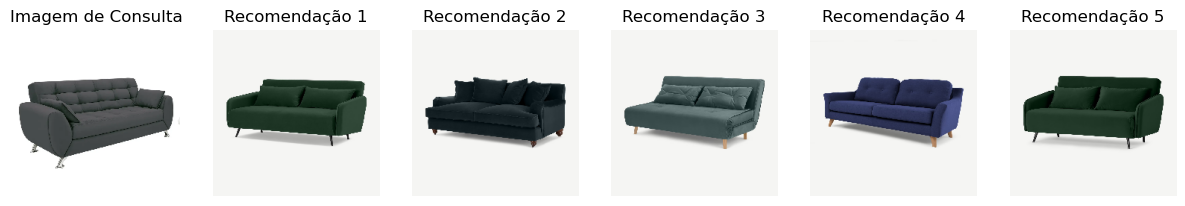

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


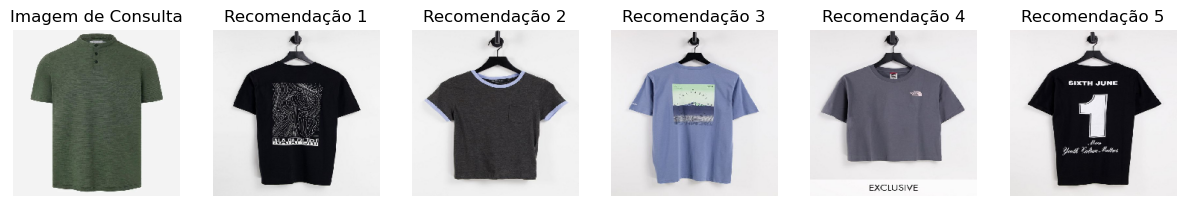

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


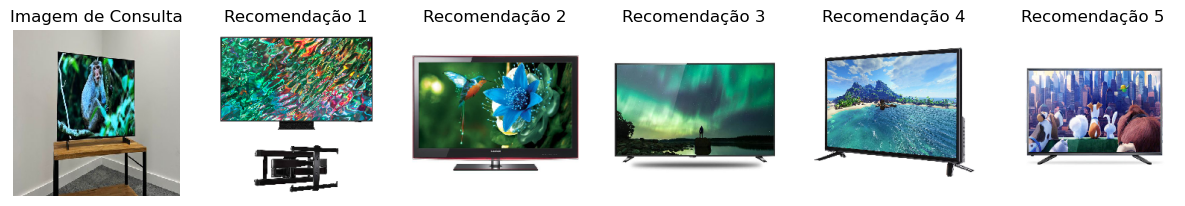

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


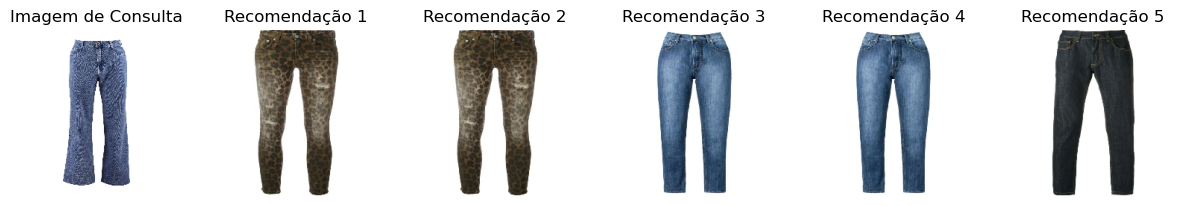

In [10]:
# Caminho para a imagem de consulta
imagem_consulta = ['imagens_para_teste/sofa.jpg', 'imagens_para_teste/tshirt.jpg', 'imagens_para_teste/tv.jpg', 'imagens_para_teste/jeans.jpg']

# Obter imagens recomendadas
for imagem in imagem_consulta:
    imagens_recomendadas = recomendar_imagens(
        caminho_consulta=imagem,
        lista_caracteristicas=lista_caracteristicas,
        lista_caminhos=lista_caminhos,
        modelo=model,
        top_n=5
    )
    
    # Visualizar as recomendações
    visualizar_recomendacoes(imagem, imagens_recomendadas)
